In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph, piecewise_extraction

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import utils

In [3]:
param_file = 'CtP_param.json'
param_file = Path('../0_data/manual').resolve().joinpath(param_file)

In [4]:
# Model training is param #3 (network is 1, hyperparmas is 2)
out_dir = utils.read_data_param(param_file)[2]

In [5]:
tgt_node, tgt_edge = utils.load_targets(param_file)

In [6]:
nodes, edges = utils.load_network(param_file)

In [7]:
best_param, features = utils.load_hyperparameters(param_file)

In [8]:
print('{:,} Nodes'.format(len(nodes)))
print('{:,} Edges'.format(len(edges)))

250,035 Nodes
9,652,116 Edges


In [9]:
best_param

{'C': 0.006334718111182533,
 'l1_ratio': 0.029991113106311307,
 'w': 0.5665616931869023}

## Routine for extracting information

In [10]:
%%time
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', tgt_node, max_length=4, w=best_param['w'], n_jobs=32)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:54<00:00,  1.24it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:26<00:00,  2.54it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 115.46it/s]


CPU times: user 41.2 s, sys: 22.3 s, total: 1min 3s
Wall time: 2min 26s


In [11]:
# Ensure that we have float64 matrices"
mg.degree_weighted_matrices[tgt_edge.split('_')[-1]]

<40766x5428 sparse matrix of type '<class 'numpy.float64'>'
	with 3478 stored elements in Compressed Sparse Column format>

#### Right away lets get the true positives as we will need them later

In [12]:
pos_tups = (mg.edge_df.query('type == @tgt_edge')[['start_id', 'end_id']]
                      .apply(tuple, axis=1)
                      .tolist())
pos_tups = set(pos_tups)

In [13]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()

In [14]:
neg_frac = 0.1
rs = 20201117

tgt_comps = set(edges.query('type == @tgt_edge')['start_id'])
# Sample the negatives and subsample, but not Reframe negatvies... keep them as 'Unknown'
keep_comps = set(nodes.query('id not in @tgt_comps and id not in @ref_c and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id'])
# Merge togetehr
keep_comps = sorted(list(keep_comps | tgt_comps))

# Get our target type 
tgt_endp = set(edges.query('type == @tgt_edge')['end_id'])
# Sample the negatives and subsample cv
keep_endp = set(nodes.query('label == @tgt_node and id not in @tgt_endp')
                    .sample(frac=neg_frac, random_state=rs+1)['id'])
# Merge together
keep_endp = sorted(list(keep_endp | tgt_endp))

In [15]:
print(len(keep_comps), len(keep_endp))
print('{:,}'.format(len(keep_comps) * len(keep_endp)))
print('{:,}'.format(len(keep_comps) * len(keep_endp) * len(features)))

5362 838
4,493,356
1,199,726,052


In [16]:
def display_time(seconds):
    result = []
    
    intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )


    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{:1.0f} {}".format(value, name))
    return ', '.join(result)

In [17]:
from data_tools.ml import get_model_coefs, MeanScaledArcsinhTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

In [18]:
enet_params = {k: v for k, v in best_param.items() if k != 'w'}

post_extraction_pipeline = Pipeline(
    [('transformer', MeanScaledArcsinhTransformer()),
     ('maxabs_scale', MaxAbsScaler()),
     ('e_net', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000,
                                  random_state=rs+11, **enet_params))], verbose=True)

In [19]:
%%time

start = time()

(pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=features, start_nodes=keep_comps, end_nodes=keep_endp, 
                   return_sparse=True, sparse_df=False, verbose=True, n_jobs=30)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 267/267 [00:16<00:00, 16.59it/s]



Reshaping Result Matrices...


100%|██████████| 267/267 [00:03<00:00, 87.43it/s] 


Stacking columns...
CPU times: user 10.6 s, sys: 6.33 s, total: 16.9 s
Wall time: 29.7 s


In [20]:
print('Getting Target Values')
y = []
for row in tqdm(pairs.itertuples(), total=len(pairs)):
    # pos_tups defined several cells above
    if set([(row.chemicalsubstance_id, getattr(row, tgt_node.lower()+'_id'))]) & pos_tups:
        y.append(1)
    else:
        y.append(0)

y = np.array(y)
pairs['status'] = y

print('Getting training subset')
# subset so that we're training only with nonzero dwpc rows
# Get the training examples that have metapaths
nz_index = pairs[dwpc.getnnz(1)>0].index
# have the number of postivies to get 100x this for the negatives.
n_pos = pairs['status'].sum()
# Sample the nonzero negative examples at a rate of 100x the positive samples
neg_index = pairs.loc[nz_index].query('status == 0').sample(n=100*n_pos, random_state=rs+10).sort_index().index
# and of course take the training postivies
pos_index = pairs.query('status == 1').index
# Union the two
train_index = pos_index.union(neg_index)

# Fit the model and get results
print('Training Model')
post_extraction_pipeline.fit(dwpc[train_index, :], y[train_index])

Getting Target Values



Getting training subset
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.0s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total= 3.3min


Pipeline(steps=[('transformer',
                 <data_tools.ml.MeanScaledArcsinhTransformer object at 0x7fd4bec070f0>),
                ('maxabs_scale', MaxAbsScaler()),
                ('e_net',
                 LogisticRegression(C=0.006334718111182533,
                                    l1_ratio=0.029991113106311307,
                                    max_iter=5000, penalty='elasticnet',
                                    random_state=20201128, solver='saga'))],
         verbose=True)

In [21]:
# Get coef
print('Getting Model Coef')
trans_dwpc = post_extraction_pipeline[1].transform(post_extraction_pipeline[0].transform(dwpc[train_index, :]))

coef = get_model_coefs(post_extraction_pipeline[-1], trans_dwpc, features).sort_values('coef', ascending=False)

print('Training took: ' + display_time(time() - start))
print('\n\n')

Getting Model Coef
Training took: 4 minutes, 3 seconds





In [22]:
utils.save_model(post_extraction_pipeline, out_mp, coef, out_dir)

In [23]:
coef.head(10)

,feature,coef,zcoef
2,CafBPawP,0.675579,0.0741404
5,CafGmP,0.513517,0.0437169
197,CafGpoPWpoCtP,0.450789,0.0364451
51,CawPWpoGtP,0.436773,0.0440959
34,CafGpoBPawP,0.410195,0.0487993
50,CawPWpoGmP,0.391452,0.0444934
37,CafGrxCtP,0.365766,0.0189605
1,CaBPawP,0.358885,0.0389757
257,CawPWpoGpr>GtP,0.343407,0.0220677
44,CinGpoBPawP,0.339265,0.0459329


In [24]:
len(coef.query('coef != 0')) - 1

229

In [25]:
%%time

start = time()
        
# Fit the model and get results
print('Getting Probabilities')
y_proba = post_extraction_pipeline.predict_proba(dwpc)[:, 1]

Getting Probabilities
CPU times: user 17.9 s, sys: 1.59 s, total: 19.5 s
Wall time: 19.5 s


In [26]:
# Get metrics
print('Metrics on training data')
roc_auc = roc_auc_score(y, y_proba)
avg_prec = average_precision_score(y, y_proba)
print('AUROC: {:1.4f}'.format(roc_auc))
print('AUPR: {:1.4f}'.format(avg_prec))

Metrics on training data
AUROC: 0.8689
AUPR: 0.0718


In [27]:
pairs['status'] = y
pairs['proba'] = y_proba

# Save results
pairs.to_csv(out_dir.joinpath('results.csv'), index=False)

print('Eval took: ' + display_time(time() - start))
print('\n\n')

Eval took: 34 seconds





## Load back in all the results and plot

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_tools import plotting as pt

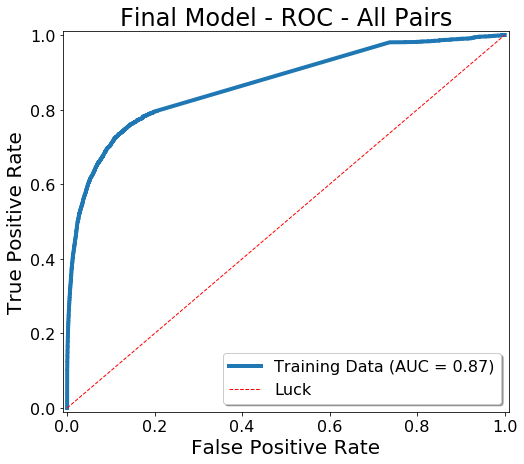

In [29]:
pt.graph_single_roc(y, y_proba, 'Training Data')
pt.graph_roc_boilerplate('Final Model - ROC - All Pairs');

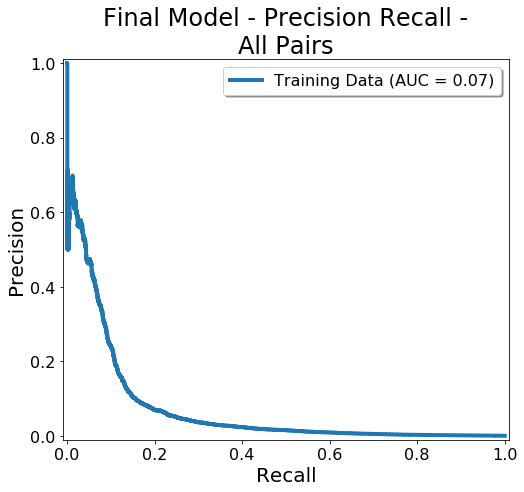

In [30]:
pt.graph_single_prc(y, y_proba, 'Training Data')
pt.graph_prc_boilerplate('Final Model - Precision Recall -\nAll Pairs');

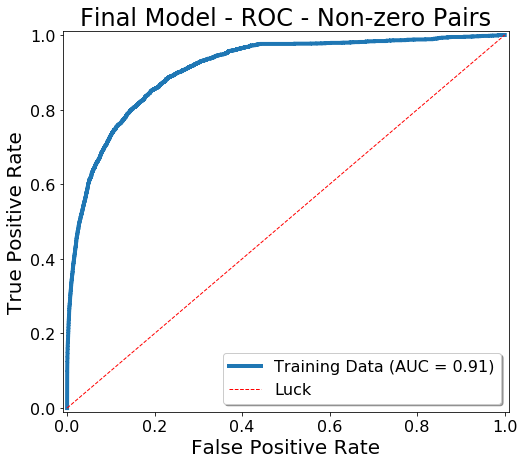

In [31]:
pt.graph_single_roc(y[nz_index], y_proba[nz_index], 'Training Data')
pt.graph_roc_boilerplate('Final Model - ROC - Non-zero Pairs');

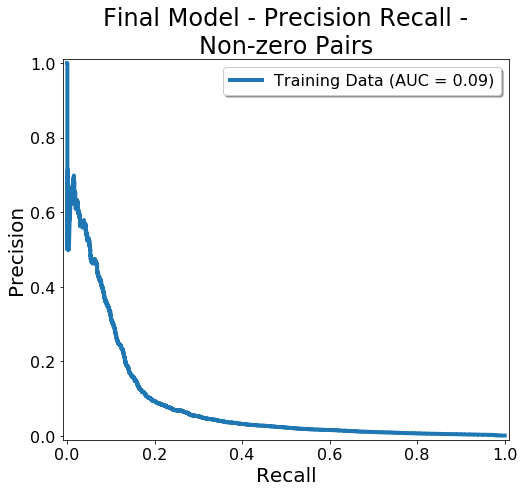

In [32]:
pt.graph_single_prc(y[nz_index], y_proba[nz_index], 'Training Data')
pt.graph_prc_boilerplate('Final Model - Precision Recall -\nNon-zero Pairs');

In [34]:
id_to_name = nodes.set_index('id')['name'].to_dict()
pairs['chem'] = pairs['chemicalsubstance_id'].map(id_to_name)
pairs['p'] = pairs[tgt_node.lower()+'_id'].map(id_to_name)

In [35]:
pairs.head(10)

,chemicalsubstance_id,phenotypicfeature_id,status,proba,chem,p
0,CHEBI:100147,HP:0000010,0,0.006826,nalidixic acid,Recurrent urinary tract infections
1,CHEBI:100147,HP:0000012,0,0.005410,nalidixic acid,Urinary urgency
2,CHEBI:100147,HP:0000016,0,0.008298,nalidixic acid,Urinary retention
3,CHEBI:100147,HP:0000017,0,0.005579,nalidixic acid,Nocturia
4,CHEBI:100147,HP:0000020,0,0.006149,nalidixic acid,Urinary incontinence
5,CHEBI:100147,HP:0000034,0,0.005541,nalidixic acid,Hydrocele testis
6,CHEBI:100147,HP:0000044,0,0.006501,nalidixic acid,Hypogonadotrophic hypogonadism
7,CHEBI:100147,HP:0000048,0,0.005432,nalidixic acid,Bifid scrotum
8,CHEBI:100147,HP:0000062,0,0.006291,nalidixic acid,Ambiguous genitalia
9,CHEBI:100147,HP:0000079,0,0.005390,nalidixic acid,Abnormality of the urinary system


In [43]:
pairs = pairs.sort_values('proba', ascending=False).reset_index(drop=True)

In [44]:
pairs.head(50)

,chemicalsubstance_id,phenotypicfeature_id,status,proba,chem,p
0,UNII:OHF2F5C0ZH,MESH:D007249,1,0.965170,Tetrachlorodibenzodioxin,inflammation
1,CHEBI:29081,MESH:D007249,1,0.960279,synephrine,inflammation
2,CHEBI:16469,MESH:D007249,0,0.959492,17beta-estradiol,inflammation
3,MESH:D004041,MESH:D007249,0,0.957998,Dietary Fats,inflammation
4,MESH:D010936,MESH:D007249,1,0.956257,Plant Extracts,inflammation
5,CHEBI:45713,MESH:D007249,1,0.956232,trans-resveratrol,inflammation
6,MESH:D014028,MESH:D007249,1,0.952573,Tobacco Smoke Pollution,inflammation
7,MESH:D008070,MESH:D007249,0,0.951895,Lipopolysaccharides,inflammation
8,CHEBI:8876,MESH:D007249,1,0.949247,robinetin,inflammation
9,CHEBI:29865,MESH:D007249,0,0.948567,benzo[a]pyrene,inflammation


In [45]:
pairs.query('status == 0').head(50)

,chemicalsubstance_id,phenotypicfeature_id,status,proba,chem,p
2,CHEBI:16469,MESH:D007249,0,0.959492,17beta-estradiol,inflammation
3,MESH:D004041,MESH:D007249,0,0.957998,Dietary Fats,inflammation
7,MESH:D008070,MESH:D007249,0,0.951895,Lipopolysaccharides,inflammation
9,CHEBI:29865,MESH:D007249,0,0.948567,benzo[a]pyrene,inflammation
11,CHEBI:28748,MESH:D007249,0,0.945985,doxorubicin,inflammation
13,CHEBI:26689,MESH:D007249,0,0.942200,O2,inflammation
14,CHEBI:39867,MESH:D007249,0,0.941968,valproic acid,inflammation
15,CHEBI:31580,MESH:D007249,0,0.941340,ethynodiol diacetate,inflammation
17,CHEBI:5819,MESH:D007249,0,0.939632,hydroxyzine hydrochloride,inflammation
20,CHEBI:53795,MESH:D007249,0,0.935171,(R)-amlodipine,inflammation


In [46]:
pairs.query('status == 0').drop_duplicates(subset=['chemicalsubstance_id']).head(50)

,chemicalsubstance_id,phenotypicfeature_id,status,proba,chem,p
2,CHEBI:16469,MESH:D007249,0,0.959492,17beta-estradiol,inflammation
3,MESH:D004041,MESH:D007249,0,0.957998,Dietary Fats,inflammation
7,MESH:D008070,MESH:D007249,0,0.951895,Lipopolysaccharides,inflammation
9,CHEBI:29865,MESH:D007249,0,0.948567,benzo[a]pyrene,inflammation
11,CHEBI:28748,MESH:D007249,0,0.945985,doxorubicin,inflammation
13,CHEBI:26689,MESH:D007249,0,0.942200,O2,inflammation
14,CHEBI:39867,MESH:D007249,0,0.941968,valproic acid,inflammation
15,CHEBI:31580,MESH:D007249,0,0.941340,ethynodiol diacetate,inflammation
17,CHEBI:5819,MESH:D007249,0,0.939632,hydroxyzine hydrochloride,inflammation
20,CHEBI:53795,MESH:D007249,0,0.935171,(R)-amlodipine,inflammation


In [47]:
pairs.query('status == 0').drop_duplicates(subset=[tgt_node.lower()+'_id']).head(50)

,chemicalsubstance_id,phenotypicfeature_id,status,proba,chem,p
2,CHEBI:16469,MESH:D007249,0,0.959492,17beta-estradiol,inflammation
271,UNII:OHF2F5C0ZH,MESH:D008654,0,0.774888,Tetrachlorodibenzodioxin,mesothelioma
308,MESH:D004041,MESH:D006940,0,0.754659,Dietary Fats,hyperaemia
336,UNII:OHF2F5C0ZH,HP:0002097,0,0.734356,Tetrachlorodibenzodioxin,Emphysema
384,UNII:OHF2F5C0ZH,HP:0001342,0,0.708420,Tetrachlorodibenzodioxin,Cerebral hemorrhage
499,CHEBI:10033,HP:0004936,0,0.649817,warfarin,Venous thrombosis
501,UNII:OHF2F5C0ZH,MESH:D012130,0,0.649186,Tetrachlorodibenzodioxin,respiratory hypersensitivity
590,CHEBI:10033,HP:0002625,0,0.604116,warfarin,Deep venous thrombosis
607,CHEBI:6344,HP:0002615,0,0.596681,Labetalol hydrochloride,Hypotension
912,CHEBI:10093,HP:0001662,0,0.479205,yohimbine,Bradycardia
